In [1]:
import numpy as np
import os
import pydotplus
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from treeinterpreter import treeinterpreter as ti
import pymc3 as pm
import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import validation_curve, GridSearchCV
from theano import shared
from pymc3 import  *
import graphviz

import datetime as dt

/home/pt18419/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = datasets.fetch_california_housing()

In [3]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['median_house_value'] = data.target
df=df.loc[df['median_house_value']<5.00001,:]
df=df.loc[df['HouseAge']<52,:]
df['bedroomsvsrooms']=df['AveBedrms']/df['AveRooms']
df['roomsvsoccupancy']=df['AveRooms']/df['AveOccup']
df = df.drop('AveRooms', axis=1)
df = df.drop('AveBedrms', axis=1)
df = df.drop('AveOccup', axis=1)

In [4]:
df

,MedInc,HouseAge,Population,Latitude,Longitude,median_house_value,bedroomsvsrooms,roomsvsoccupancy
0,8.3252,41.0,322.0,37.88,-122.23,4.526,0.146591,2.732919
1,8.3014,21.0,2401.0,37.86,-122.22,3.585,0.155797,2.956685
8,2.0804,42.0,1206.0,37.84,-122.26,2.267,0.260274,2.118574
15,2.1250,50.0,697.0,37.85,-122.26,1.400,0.252679,1.606887
18,1.9911,50.0,990.0,37.84,-122.26,1.587,0.203216,2.261616
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,845.0,39.48,-121.09,0.781,0.224625,1.970414
20636,2.5568,18.0,356.0,39.49,-121.21,0.771,0.215208,1.957865
20637,1.7000,17.0,1007.0,39.43,-121.22,0.923,0.215173,2.238332
20638,1.8672,18.0,741.0,39.43,-121.32,0.847,0.219892,2.510121


In [5]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
scaler = StandardScaler()
X_std_train = scaler.fit_transform(X_train)
print(X_std_train.shape)
X_std_test = scaler.transform(X_test)
print(X_std_test.shape)

(13929, 7)
(4643, 7)


In [8]:
regr = RandomForestRegressor(max_depth=48, n_estimators=300, criterion='mse', n_jobs=-1)

In [35]:
regr.fit(X_std_train, y_train)

RandomForestRegressor(max_depth=48, n_estimators=300, n_jobs=-1)

In [36]:
y_pred = regr.predict(X_std_test)

In [37]:
mse = metrics.mean_squared_error(y_pred, y_test)
mse = np.sqrt(mse)
print(mse)

0.4473328382070968


In [149]:
mses = []
for i in range(1, 51):
    temp = RandomForestRegressor(max_depth=i, criterion='mse', n_jobs=-1)
    temp.fit(X_std_train, y_train)
    y_pred = temp.predict(X_std_test)
    mse = metrics.mean_squared_error(y_pred, y_test)
    mses.append(np.sqrt(mse))

Text(0, 0.5, 'mse')

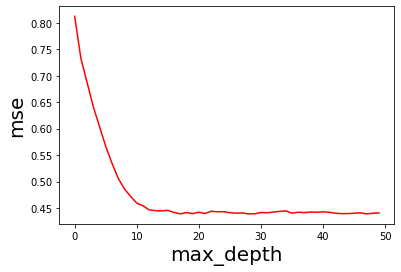

In [153]:
plt.plot(mses, c='red')
plt.xlabel("max_depth", fontsize=20)
plt.ylabel("mse", fontsize=20)

In [219]:
degree = [x for x in range(1,100)]
train_score, val_score = validation_curve(RandomForestRegressor(criterion='mse', n_jobs=-1), X_std_train, y_train,
                                          'n_estimators', degree, cv=2, scoring='neg_root_mean_squared_error')

/home/pt18419/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=n_estimators, param_range=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Text(0, 0.5, 'mse')

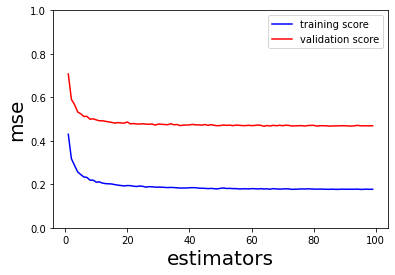

In [220]:
plt.plot(degree, np.abs(np.median(train_score, 1)), color='blue', label='training score')
plt.plot(degree, np.abs(np.median(val_score, 1)), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('estimators', fontsize=20)
plt.ylabel('mse', fontsize=20)

In [224]:
degree_samples = [x for x in range(2,200)]
train_score_samples, val_score_samples = validation_curve(RandomForestRegressor(criterion='mse', n_jobs=-1), X_std_train, y_train,
                                          'min_samples_split', degree_samples, cv=2, scoring='neg_root_mean_squared_error')

/home/pt18419/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=min_samples_split, param_range=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 19

Text(0, 0.5, 'mse')

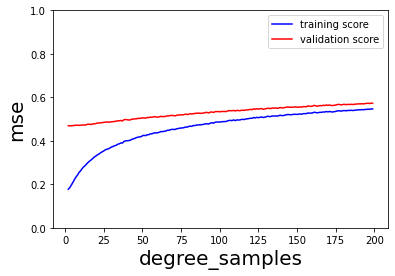

In [226]:
plt.plot(degree_samples, np.abs(np.median(train_score_samples, 1)), color='blue', label='training score')
plt.plot(degree_samples, np.abs(np.median(val_score_samples, 1)), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree_samples', fontsize=20)
plt.ylabel('mse', fontsize=20)

In [74]:
degree_features = [1,2,3,4,5,5,7]
train_score_features, val_score_features = validation_curve(RandomForestRegressor(criterion='mse', n_jobs=-1), X_std_train, y_train,
                                          'max_features', degree_features, cv=10, scoring='neg_root_mean_squared_error')

/home/pt18419/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_features, param_range=[1, 2, 3, 4, 5, 5, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Text(0, 0.5, 'mse')

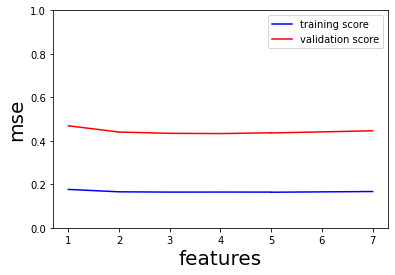

In [75]:
plt.plot(degree_features, np.abs(np.median(train_score_features, 1)), color='blue', label='training score')
plt.plot(degree_features, np.abs(np.median(val_score_features, 1)), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('features', fontsize=20)
plt.ylabel('mse', fontsize=20)

In [76]:
parameters = {'max_features':[x for x in range(1,8)]} 
clf_features = GridSearchCV(RandomForestRegressor(), param_grid=parameters, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
clf_features.fit(X_std_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7]},
             scoring='neg_root_mean_squared_error')

In [77]:
clf_features.best_params_

{'max_features': 4}

In [52]:
parameters = {'max_depth':[x for x in range(1,51)]} 
clf = GridSearchCV(RandomForestRegressor(), param_grid=parameters, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
clf.fit(X_std_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_root_mean_squared_error')

In [53]:
clf.best_params_

{'max_depth': 48}

In [55]:
times = []
prediction_acc = []
for i in range(1,81):
    start_time = dt.datetime.now()
    for j in range(0,10):
        temp = RandomForestRegressor(max_depth=i, criterion='mse', n_jobs=-1)
        temp.fit(X_std_train, y_train)
        y_pred = temp.predict(X_std_test)
    elapsed_time = (dt.datetime.now() - start_time)/10
    print('Prediction takes {}'.format(str(elapsed_time)))
    times.append(elapsed_time)
    mse = metrics.mean_squared_error(y_pred, y_test)
    prediction_acc.append(np.sqrt(mse))

Prediction takes 0:00:02.133459
Prediction takes 0:00:02.137087
Prediction takes 0:00:02.113064
Prediction takes 0:00:02.128252
Prediction takes 0:00:02.164689
Prediction takes 0:00:02.193922
Prediction takes 0:00:02.333026
Prediction takes 0:00:02.317672
Prediction takes 0:00:02.229977
Prediction takes 0:00:02.141096
Prediction takes 0:00:02.217452
Prediction takes 0:00:02.547150
Prediction takes 0:00:02.587397
Prediction takes 0:00:02.459106
Prediction takes 0:00:02.352910
Prediction takes 0:00:02.390671
Prediction takes 0:00:02.594461
Prediction takes 0:00:02.364154
Prediction takes 0:00:02.384262
Prediction takes 0:00:02.414571
Prediction takes 0:00:02.395035
Prediction takes 0:00:02.381386
Prediction takes 0:00:02.365245
Prediction takes 0:00:02.376821
Prediction takes 0:00:02.371338
Prediction takes 0:00:02.355185
Prediction takes 0:00:02.483466
Prediction takes 0:00:02.432369
Prediction takes 0:00:02.466263


In [62]:
for i in range(0,80):
    times[i] = str(times[i].seconds) + "." + str(times[i].microseconds) 

In [64]:
for i in range(0,80):
    times[i] = float(times[i])

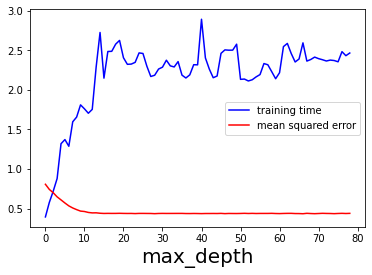

In [73]:
plt.plot(times, c='b', label='training time')
plt.plot(predicition_acc, c='r', label='mean squared error')
plt.xlabel("max_depth", fontsize=20)
plt.legend()

In [102]:
times_estimators = []
prediction_acc_estimators = []
for _,e in enumerate([10,50,100,200,300,400,500,1000]):
    start_time = dt.datetime.now()
    for j in range(0,10):
        temp = RandomForestRegressor(n_estimators=e, criterion='mse', n_jobs=-1)
        temp.fit(X_std_train, y_train)
        y_pred = temp.predict(X_std_test)
    elapsed_time = (dt.datetime.now() - start_time)/10
    print('Prediction takes {}'.format(str(elapsed_time)))
    times_estimators.append(elapsed_time)
    mse = metrics.mean_squared_error(y_pred, y_test)
    prediction_acc_estimators.append(np.sqrt(mse))

Prediction takes 0:00:00.501241
Prediction takes 0:00:01.256848
Prediction takes 0:00:02.224125
Prediction takes 0:00:04.335152
Prediction takes 0:00:07.606390
Prediction takes 0:00:09.964930
Prediction takes 0:00:12.412942
Prediction takes 0:00:24.345428


In [103]:
for i in range(0,8):
    times_estimators[i] = str(times_estimators[i].seconds) + "." + str(times_estimators[i].microseconds)
for i in range(0,8):
    times_estimators[i] = float(times_estimators[i])

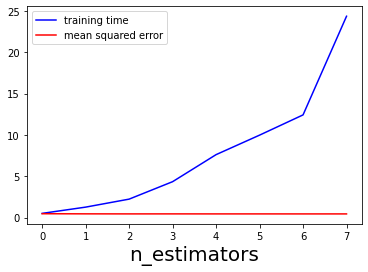

In [105]:
plt.plot(times_estimators, c='b', label='training time')
plt.plot(prediction_acc_estimators, c='r', label='mean squared error')
plt.xlabel("n_estimators", fontsize=20)
plt.legend()

In [135]:
regr2 = RandomForestRegressor(max_depth=3, criterion='mse', n_jobs=-1)
regr2.fit(X_std_train, y_train)
y_pred2 = regr2.predict(X_std_test)
mse2 = metrics.mean_squared_error(y_pred2, y_test)
mse2 = np.sqrt(mse2)
print(mse2)

0.6994444333585011


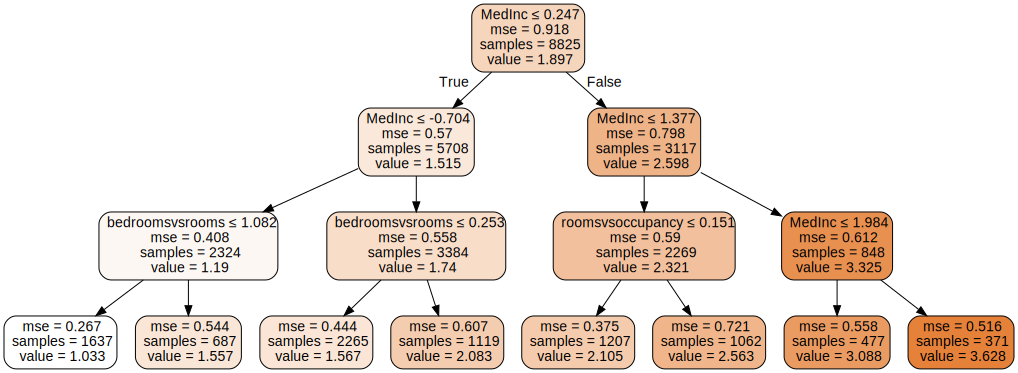

In [147]:
dot_data = sklearn.tree.export_graphviz(regr2.estimators_[0], out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("tree", format='png')
display(graph)

In [165]:
regr3 = RandomForestRegressor(max_depth=48, criterion='mse', n_jobs=-1)
regr3.fit(X_std_train, y_train)
y_pred3 = regr3.predict(X_std_test)
mse3 = metrics.mean_squared_error(y_pred3, y_test)
mse3 = np.sqrt(mse3)
print(mse3)

0.44890276914212784


In [175]:
test_tree = X_std_test[:2]
prediction, biases, contributions = ti.predict(regr3, test_tree)
for i in range(len(test_tree)):
    print("Instance", i)
    print("Bias (trainset mean)", biases[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], X.columns)):
        print(feature, round(c, 2))
    print("-"*20)

Instance 0
Bias (trainset mean) 1.899003397257512
Feature contributions:
roomsvsoccupancy -0.48
Population -0.11
HouseAge -0.1
Longitude -0.05
bedroomsvsrooms -0.02
Latitude 0.02
MedInc 0.67
--------------------
Instance 1
Bias (trainset mean) 1.899003397257512
Feature contributions:
MedInc -0.08
Population -0.02
Latitude -0.01
roomsvsoccupancy 0.14
HouseAge 0.22
Longitude 0.36
bedroomsvsrooms 0.59
--------------------


In [179]:
print(prediction)
print(biases + np.sum(contributions, axis=1))

[[1.8367 ]
 [3.11668]]
[1.8367  3.11668]


In [180]:
regr3.predict(test_tree)

array([1.8367 , 3.11668])

In [10]:
class Pymc3Model(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = pm.Model()
    
    def fit(self, X, y):
        with self.model:
            self.X_shared = shared(X)
            intercept = pm.Normal('intercept', mu=0, sd=1.)
            coeff1 = pm.Normal('coeff1', mu=0, sd=10)
            coeff2 = pm.Normal('coeff2', mu=0, sd=10)
            coeff3 = pm.Normal('coeff3', mu=0, sd=10)
            w1 = np.array([.5, .5])
            mu1 = np.array([-1, 1])
            sd1 = np.array([.1, .1])
            coeff4 = pm.NormalMixture('coeff4', w=w1, mu=mu1, sd=sd1)
            w2 = np.array([.5, .5])
            mu2 = np.array([-1.5, 1])
            sd2 = np.array([.1, .1])
            coeff5 = pm.NormalMixture('coeff5', w=w2, mu=mu2, sd=sd2)
            coeff6 = pm.Normal('coeff6', mu=0, sd=10)
            coeff7 = pm.Normal('coeff7', mu=0, sd=10)
            sigma = pm.Gamma('sigma', alpha=2, beta=1)

            y_est = intercept + coeff1*self.X_shared[:, 0] + coeff2*self.X_shared[:, 1] + coeff3*self.X_shared[:, 2] + coeff4*self.X_shared[:, 3] + coeff5*self.X_shared[:, 4] + coeff6*self.X_shared[:, 5] + coeff7*self.X_shared[:, 6]
    
            y = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
        
            self.trace = pm.sample(2000, tune=1000, progressbar=True, cores=4, chains=2)
            return self
    
    def predict(self, X):
        with self.model:
            self.X_shared.set_value(X)
            ppc = pm.sample_posterior_predictive(self.trace, samples=4000)
            y_pred = ppc['y']
            expected_y_pred = np.reshape(np.mean(y_pred, axis=0), [-1])
        return expected_y_pred

In [175]:
estimators = [('pymc3model', Pymc3Model()),
              ('randomforest', RandomForestRegressor(max_depth=48, n_estimators=300, max_features=4))]

In [176]:
stacker = StackingRegressor(estimators=estimators)

In [177]:
stacker.fit(X_std_train, y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 51 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 52 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 48 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 49 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 47 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.


StackingRegressor(estimators=[('pymc3model', Pymc3Model()),
                              ('randomforest',
                               RandomForestRegressor(max_depth=48,
                                                     max_features=4,
                                                     n_estimators=300))])

In [178]:
y_pred_stacker = stacker.predict(X_std_test)

In [180]:
mse_stacker = metrics.mean_squared_error(y_pred_stacker, y_test)
mse_stacker = np.sqrt(mse_stacker)
print(mse_stacker)

0.435952569548093


In [41]:
regr = RandomForestRegressor(max_depth=10, n_estimators=100, criterion='mse', n_jobs=-1)
regr.fit(X_std_train, y_train)
y_pred = regr.predict(X_std_test)
mse = metrics.mean_squared_error(y_pred, y_test)
mse = np.sqrt(mse)
print(mse)

0.47901571251080144


In [22]:
estimators2 = [('pymc3model', Pymc3Model()),
              ('randomforest', RandomForestRegressor(max_depth=5, n_estimators=10, max_features=4))]

In [23]:
stacker2 = StackingRegressor(estimators=estimators2)

In [24]:
stacker2.fit(X_std_train, y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 48 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 45 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 43 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 51 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 45 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 47 seconds.


StackingRegressor(estimators=[('pymc3model', Pymc3Model()),
                              ('randomforest',
                               RandomForestRegressor(max_depth=5,
                                                     max_features=4,
                                                     n_estimators=10))])

In [25]:
y_pred_stacker2 = stacker2.predict(X_std_test)

In [26]:
mse_stacker2 = metrics.mean_squared_error(y_pred_stacker2, y_test)
mse_stacker2 = np.sqrt(mse_stacker2)
print(mse_stacker2)

0.568275739800346


In [82]:
estimators4 = [('randomforest1', RandomForestRegressor(max_depth=5, n_estimators=100, max_features=4)),
               ('randomforest2', RandomForestRegressor(max_depth=15, n_estimators=100, max_features=4)),
               ('randomforest3', RandomForestRegressor(max_depth=20, n_estimators=100, max_features=4)),
               ('pymc3model', Pymc3Model())]
stacker4 = StackingRegressor(estimators=estimators4, final_estimator=RandomForestRegressor(max_depth=20, n_estimators=100, max_features=4))
stacker4.fit(X_std_train, y_train)
y_pred_stacker4 = stacker3.predict(X_std_test)
mse_stacker4 = metrics.mean_squared_error(y_pred_stacker4, y_test)
mse_stacker4 = np.sqrt(mse_stacker4)
print(mse_stacker4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 49 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 47 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 46 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 48 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 46 seconds.


0.5069959336802001


In [35]:
estimators3 = [('randomforest1', RandomForestRegressor(max_depth=5, n_estimators=100, max_features=4)),
               ('randomforest2', RandomForestRegressor(max_depth=10, n_estimators=200, max_features=4)),
               ('randomforest3', RandomForestRegressor(max_depth=20, n_estimators=300, max_features=4)),
               ('randomforest4', RandomForestRegressor(max_depth=48, n_estimators=500, max_features=4)),
               ('pymc3model', Pymc3Model())]
stacker3 = StackingRegressor(estimators=estimators3)
stacker3.fit(X_std_train, y_train)
y_pred_stacker3 = stacker3.predict(X_std_test)
mse_stacker3 = metrics.mean_squared_error(y_pred_stacker3, y_test)
mse_stacker3 = np.sqrt(mse_stacker3)
print(mse_stacker3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 50 seconds.
The acceptance probability does not match the target. It is 0.8894893054048445, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 45 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 46 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 47 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 52 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 50 seconds.


0.4244884824013486


In [60]:
estimators3 = [('randomforest1', RandomForestRegressor(max_depth=5, n_estimators=100, max_features=4)),
               ('randomforest2', RandomForestRegressor(max_depth=15, n_estimators=100, max_features=4)),
               ('randomforest3', RandomForestRegressor(max_depth=20, n_estimators=100, max_features=4)),
               ('pymc3model', Pymc3Model())]
stacker3 = StackingRegressor(estimators=estimators3, final_estimator=DecisionTreeRegressor(max_depth=2))
stacker3.fit(X_std_train, y_train)
y_pred_stacker3 = stacker3.predict(X_std_test)
mse_stacker3 = metrics.mean_squared_error(y_pred_stacker3, y_test)
mse_stacker3 = np.sqrt(mse_stacker3)
print(mse_stacker3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 60 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 53 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 48 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 56 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 55 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coeff7, coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.


0.5069959336802001


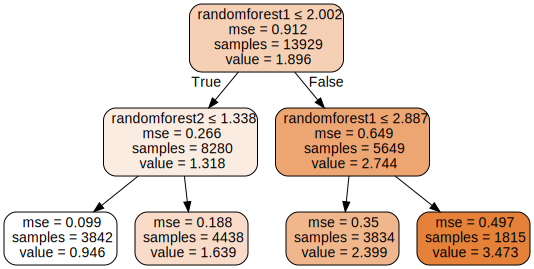

In [86]:
dot_data = sklearn.tree.export_graphviz(stacker3.final_estimator_, out_file=None, feature_names=['pymc3model', 'randomforest1', 'randomforest2', 'randomforest3'], filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("tree2", format='png')
display(graph)

[Text(167.4, 181.2, 'X[1] <= 2.002\nmse = 0.912\nsamples = 13929\nvalue = 1.896'),
 Text(83.7, 108.72, 'X[2] <= 1.338\nmse = 0.266\nsamples = 8280\nvalue = 1.318'),
 Text(41.85, 36.23999999999998, 'mse = 0.099\nsamples = 3842\nvalue = 0.946'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 0.188\nsamples = 4438\nvalue = 1.639'),
 Text(251.10000000000002, 108.72, 'X[1] <= 2.887\nmse = 0.649\nsamples = 5649\nvalue = 2.744'),
 Text(209.25, 36.23999999999998, 'mse = 0.35\nsamples = 3834\nvalue = 2.399'),
 Text(292.95, 36.23999999999998, 'mse = 0.497\nsamples = 1815\nvalue = 3.473')]

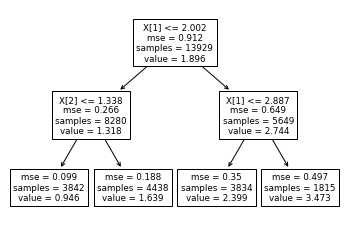

In [85]:
plot_tree(stacker3.final_estimator_)

In [40]:
estimators5 = [('randomforest1', RandomForestRegressor(max_depth=5, n_estimators=10, max_features=4)),
                ('randomforest2', RandomForestRegressor(max_depth=5, n_estimators=10, max_features=4)),
              ('randomforest3', RandomForestRegressor(max_depth=5, n_estimators=10, max_features=4)),
              ('randomforest4', RandomForestRegressor(max_depth=5, n_estimators=10, max_features=4)),
              ('randomforest5', RandomForestRegressor(max_depth=5, n_estimators=10, max_features=4))]
stacker5 = StackingRegressor(estimators=estimators5, final_estimator=RandomForestRegressor(max_depth=, n_estimators=100, max_features=4))
stacker5.fit(X_std_train, y_train)
y_pred_stacker5 = stacker5.predict(X_std_test)
mse_stacker5 = metrics.mean_squared_error(y_pred_stacker5, y_test)
mse_stacker5 = np.sqrt(mse_stacker5)
print(mse_stacker5)

0.43471344802315637


In [42]:
regr = RandomForestRegressor(max_depth=20, n_estimators=100, max_features=4)
regr.fit(X_std_train, y_train)
y_pred = regr.predict(X_std_test)
mse = metrics.mean_squared_error(y_pred, y_test)
mse = np.sqrt(mse)
print(mse)

0.4372648589610726
